# Semi-supervised image classification using contrastive pretraining with SimCLR

**Author:** [András Béres](https://www.linkedin.com/in/andras-beres-789190210)<br>
**Date created:** 2021/04/24<br>
**Last modified:** 2021/04/24<br>
**Description:** Contrastive pretraining with SimCLR for semi-supervised image classification on the STL-10 dataset.

## The Illustrated SimCLR Framework 
> [The Illustrated SimCLR Framework ](https://amitness.com/2020/03/illustrated-simclr/)

## Introduction

### Semi-supervised learning

Semi-supervised learning is a machine learning paradigm that deals with
**partially labeled datasets**. When applying deep learning in the real world,
one usually has to gather a large dataset to make it work well. However, while
the cost of labeling scales linearly with the dataset size (labeling each
example takes a constant time), model performance only scales
[sublinearly](https://arxiv.org/abs/2001.08361) with it. This means that
labeling more and more samples becomes less and less cost-efficient, while
gathering unlabeled data is generally cheap, as it is usually readily available
in large quantities.

Semi-supervised learning offers to solve this problem by only requiring a
partially labeled dataset, and by being label-efficient by utilizing the
unlabeled examples for learning as well.

In this example, we will pretrain an encoder with contrastive learning on the
[STL-10](https://ai.stanford.edu/~acoates/stl10/) semi-supervised dataset using
no labels at all, and then fine-tune it using only its labeled subset.

### Contrastive learning

On the highest level, the main idea behind contrastive learning is to **learn
representations that are invariant to image augmentations** in a self-supervised
manner. One problem with this objective is that it has a trivial degenerate
solution: the case where the representations are constant, and do not depend at all on the
input images.

Contrastive learning avoids this trap by modifying the objective in the
following way: it pulls representations of augmented versions/views of the same
image closer to each other (contracting positives), while simultaneously pushing
different images away from each other (contrasting negatives) in representation
space.

One such contrastive approach is [SimCLR](https://arxiv.org/abs/2002.05709),
which essentially identifies the core components needed to optimize this
objective, and can achieve high performance by scaling this simple approach.

Another approach is [SimSiam](https://arxiv.org/abs/2011.10566)
([Keras example](https://keras.io/examples/vision/simsiam/)),
whose main difference from
SimCLR is that the former does not use any negatives in its loss. Therefore, it does not
explicitly prevent the trivial solution, and, instead, avoids it implicitly by
architecture design (asymmetric encoding paths using a predictor network and
batch normalization (BatchNorm) are applied in the final layers).

For further reading about SimCLR, check out
[the official Google AI blog post](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html),
and for an overview of self-supervised learning across both vision and language
check out
[this blog post](https://ai.facebook.com/blog/self-supervised-learning-the-dark-matter-of-intelligence/).

## Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import torchvision
from torchinfo import summary

from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from tqdm.auto import trange

## Hyperparameter setup

In [20]:
# Dataset hyperparameters
unlabeled_dataset_size = 100000
labeled_dataset_size = 5000
image_size = 96
image_channels = 3
num_class = 10

# Algorithm hyperparameters
num_epochs = 20
# batch_size = 525  # Corresponds to 200 steps per epoch
batch_size = 210  # Corresponds to 500 steps per epoch
out_channels = 128
temperature = 0.1

# Stronger augmentations for contrastive, weaker ones for supervised training
contrastive_augmentation = {"min_area": 0.25, "brightness": 0.6, "jitter": 0.2}
classification_augmentation = {"min_area": 0.75, "brightness": 0.3, "jitter": 0.1}

## Dataset

During training we will simultaneously load a large batch of unlabeled images along with a
smaller batch of labeled images.

* STL dataset Description : https://cs.stanford.edu/~acoates/stl10/
* STL dataset for PyTorch : https://pytorch.org/vision/stable/_modules/torchvision/datasets/stl10.html

In [21]:
def prepare_dataset(path2data):

    transform = transforms.Compose([transforms.ToTensor()])
    
    # train : train + unlabaled
    unlabeled_train_dataset = datasets.STL10(path2data, split='unlabeled', download='True', transform=transform)
    labeled_train_dataset = datasets.STL10(path2data, split='train', download='True', transform=transform)
    test_dataset = datasets.STL10(path2data, split='test', download='True', transform=transform)
    
    return unlabeled_train_dataset, labeled_train_dataset, test_dataset


# Load STL10 dataset
unlabeled_train_dataset, labeled_train_dataset, test_dataset = prepare_dataset(path2data = '../datasets')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [22]:
print(unlabeled_train_dataset.data.shape)
print(labeled_train_dataset.data.shape)
print(test_dataset.data.shape)

(100000, 3, 96, 96)
(5000, 3, 96, 96)
(8000, 3, 96, 96)


* `steps_per_epoch` 으로 동일 epoch에 label/unlabel 데이터 다 돌 수 있게 batch 나눔
*  pre training 시, unlabeled 로 self-sueprvised contrastive learning, labeled로 representation의 성능 평가 수행

In [23]:
# Labeled and unlabeled samples are loaded synchronously
# with batch sizes selected accordingly
steps_per_epoch = (unlabeled_dataset_size + labeled_dataset_size) // batch_size
unlabeled_batch_size = unlabeled_dataset_size // steps_per_epoch
labeled_batch_size = labeled_dataset_size // steps_per_epoch
print(
    f"batch size is {unlabeled_batch_size} (unlabeled) + {labeled_batch_size} (labeled)"
)

batch size is 200 (unlabeled) + 10 (labeled)


In [24]:
class Dataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset.data[idx]
        label = self.dataset.labels[idx]
        return image, label

In [25]:
unlabeled_train_loader = DataLoader(Dataset(unlabeled_train_dataset), batch_size=unlabeled_batch_size, shuffle=True)
labeled_train_loader = DataLoader(Dataset(labeled_train_dataset), batch_size=labeled_batch_size, shuffle=True)
test_loader = DataLoader(Dataset(test_dataset), batch_size=batch_size, shuffle=False)

In [26]:
next(iter(unlabeled_train_loader))[0].shape

torch.Size([200, 3, 96, 96])

In [27]:
next(iter(labeled_train_loader))[0].shape

torch.Size([10, 3, 96, 96])

In [28]:
next(iter(test_loader))[0].shape

torch.Size([210, 3, 96, 96])

## Image augmentations

The two most important image augmentations for contrastive learning are the
following:

- Cropping: forces the model to encode different parts of the same image
similarly, we implement it with the
[RandomTranslation](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/random_translation/)
and
[RandomZoom](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/random_zoom/)
layers
- Color jitter: prevents a trivial color histogram-based solution to the task by
distorting color histograms. A principled way to implement that is by affine
transformations in color space.

In this example we use random horizontal flips as well. Stronger augmentations
are applied for contrastive learning, along with weaker ones for supervised
classification to avoid overfitting on the few labeled examples.

We implement random color jitter as a custom preprocessing layer. Using
preprocessing layers for data augmentation has the following two advantages:

- The data augmentation will run on GPU in batches, so the training will not be
bottlenecked by the data pipeline in environments with constrained CPU
resources (such as a Colab Notebook, or a personal machine)
- Deployment is easier as the data preprocessing pipeline is encapsulated in the
model, and does not have to be reimplemented when deploying it

In [29]:
# meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in train_dataset]
# stdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in train_dataset]

# meanR = np.mean([m[0] for m in meanRGB])
# meanG = np.mean([m[1] for m in meanRGB])
# meanB = np.mean([m[2] for m in meanRGB])

# stdR = np.mean([s[0] for s in stdRGB])
# stdG = np.mean([s[1] for s in stdRGB])
# stdB = np.mean([s[2] for s in stdRGB])

# print(meanR, meanG, meanB)
# print(stdR, stdG, stdB)

In [30]:
# stl10_mean = (0.440878, 0.42790633, 0.38678792)
# stl10_std = (0.23088025, 0.22622044, 0.22367561)

In [31]:
# https://pytorch.org/vision/main/generated/torchvision.transforms.ColorJitter.html

class TransformsSimCLR:
    
    def __init__(self, size, min_area, brightness, jitter):
        
        self.rescale = 1/255
        self.zoom_factor = 1.0 - np.sqrt(min_area)
        self.translation_factor = (-self.zoom_factor - self.zoom_factor) * torch.rand(2) + self.zoom_factor # -20% ~ + 20% 사이 랜덤 생성
        self.h = int(size[0]*(1+self.translation_factor[0]))
        self.w = int(size[1]*(1+self.translation_factor[1]))
        self.random_size = (self.h, self.w)
        self.train_transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.RandomHorizontalFlip(),  # with 0.5 probability
                torchvision.transforms.Resize(self.random_size), # random size로 translation
                transforms.RandomResizedCrop(size=size),
                transforms.ColorJitter(brightness=brightness, hue=jitter), # 명암, 색조
            ]
        )

    def __call__(self, x):
        return self.train_transform(x*self.rescale)

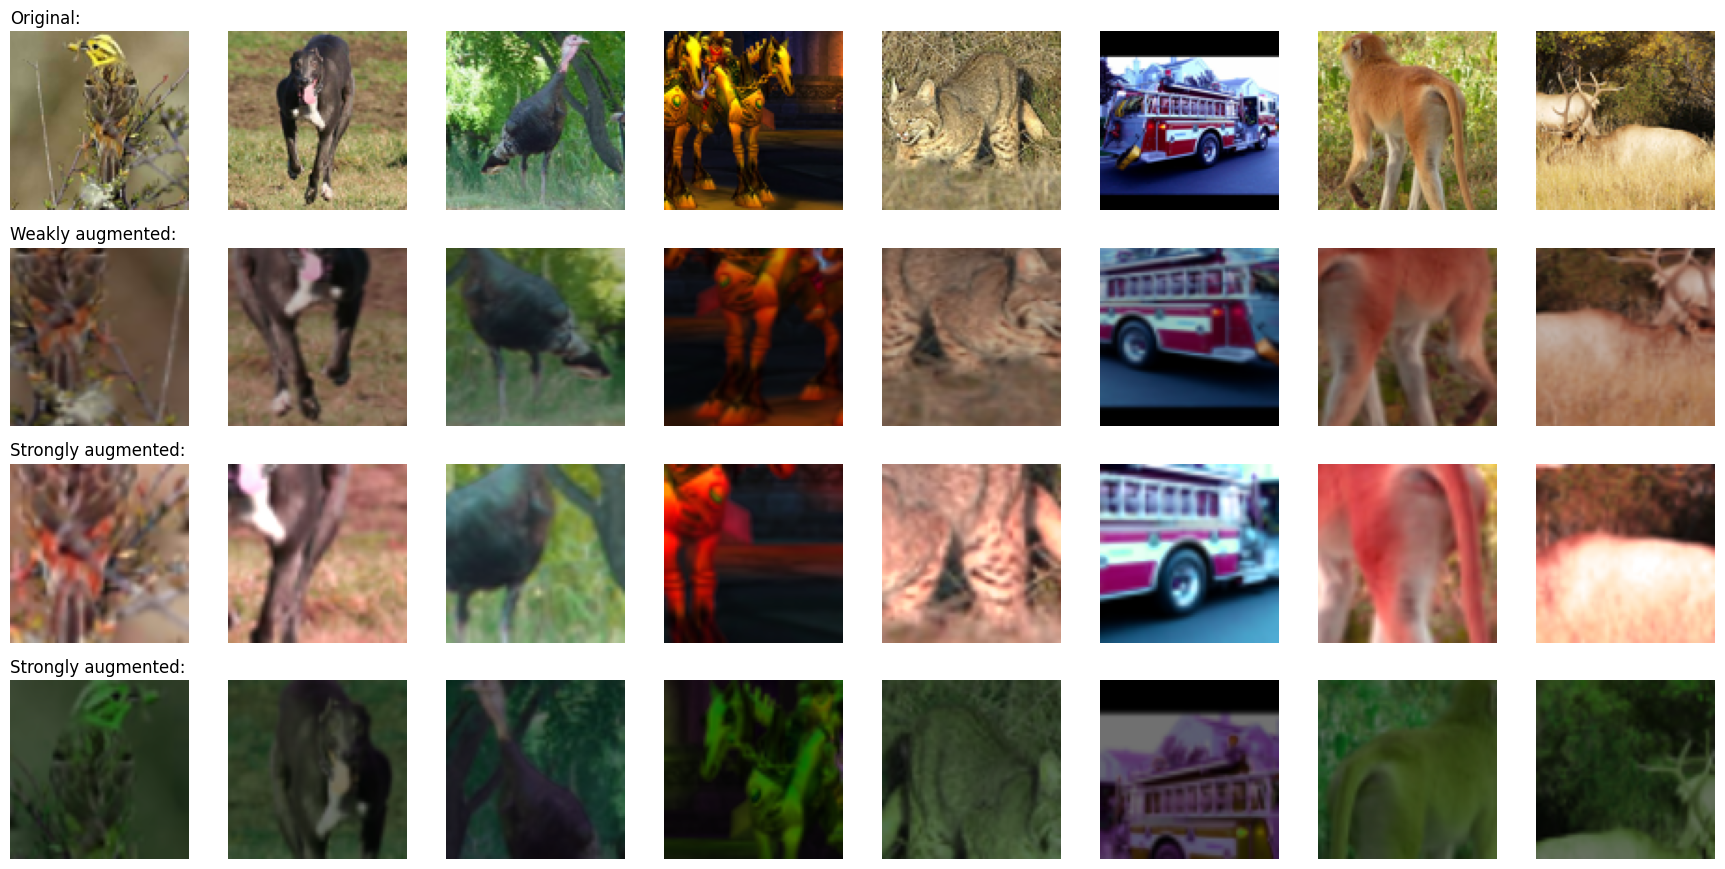

In [32]:
import matplotlib.pyplot as plt

def visualize_augmentations(num_images):
    # Sample a batch from a dataset
    images = torch.tensor(labeled_train_dataset.data[:8])
    
    # Apply augmentations
    augmented_images = zip(
        images,
        TransformsSimCLR((96,96), **classification_augmentation)(images),
        TransformsSimCLR((96,96), **contrastive_augmentation)(images),
        TransformsSimCLR((96,96), **contrastive_augmentation)(images),
    )
    
    print(augmented_images)
    row_titles = [
        "Original:",
        "Weakly augmented:",
        "Strongly augmented:",
        "Strongly augmented:",
    ]
    
    plt.figure(figsize=(num_images * 2.2, 4 * 2.2), dpi=100)
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(4, num_images, row * num_images + column + 1)
            plt.imshow(np.transpose(image, (1, 2, 0)))
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")
    plt.tight_layout()


visualize_augmentations(num_images=8)

## Encoder architecture

In [33]:
# Define the encoder architecture

class Encoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=128):
        super().__init__()
        self.out_channels = out_channels
        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2)
        self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2)
        self.conv_3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2)
        self.conv_4 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(out_channels*5*5, out_channels)
    
    def forward(self, x):
        out = F.relu(self.conv_1(x))
        out = F.relu(self.conv_2(out))
        out = F.relu(self.conv_3(out))
        out = F.relu(self.conv_4(out))
        out = self.flatten(out)
        out = F.relu(self.linear(out))
        return out

## Supervised baseline model

A baseline supervised model is trained using random initialization.

In [34]:
# Baseline supervised training with random initialization

class BaseLineModel(nn.Module):
    def __init__(self, size=(96, 96), in_channels=3, out_channels=128, num_class=10):
        super().__init__()
        self.augmenter = TransformsSimCLR(size, **classification_augmentation)
        self.encoder = Encoder(in_channels=in_channels, out_channels=out_channels)
        self.linear = nn.Linear(out_channels, num_class)
    
    def forward(self, x):
        out = self.augmenter(x)
        out = self.encoder(out)
        out = self.linear(out)
        return out

In [35]:
baseline_model = BaseLineModel(size=(96, 96), in_channels=3, out_channels=128, num_class=10)
summary(baseline_model, (25, 3, 96, 96))

Layer (type:depth-idx)                   Output Shape              Param #
BaseLineModel                            --                        --
├─Encoder: 1-1                           [25, 128]                 --
│    └─Conv2d: 2-1                       [25, 128, 47, 47]         3,584
│    └─Conv2d: 2-2                       [25, 128, 23, 23]         147,584
│    └─Conv2d: 2-3                       [25, 128, 11, 11]         147,584
│    └─Conv2d: 2-4                       [25, 128, 5, 5]           147,584
│    └─Flatten: 2-5                      [25, 3200]                --
│    └─Linear: 2-6                       [25, 128]                 409,728
├─Linear: 1-2                            [25, 10]                  1,290
Total params: 857,354
Trainable params: 857,354
Non-trainable params: 0
Total mult-adds (G): 2.70
Input size (MB): 2.76
Forward/backward pass size (MB): 73.86
Params size (MB): 3.43
Estimated Total Size (MB): 80.05

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ('Current device : ', device)

learning_rate = 0.0001
total_step = len(labeled_train_loader)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=learning_rate)

# Train the model.
print("baseline model training...")

train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

for epoch in trange(num_epochs):
    baseline_model.train()
    
    train_correct = 0
    train_total = 0
    for i, data in enumerate(labeled_train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = baseline_model(inputs) 

        predictions = torch.argmax(F.softmax(outputs, dim=-1), dim=-1)
        train_total += labels.size(0)
        train_correct += (predictions == labels).sum().item()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if (i+1)%50 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i, total_step, loss.item())) 
            
    train_loss.append(loss)
    train_accuracy = 100 * train_correct / train_total
    train_acc.append(train_accuracy)
    
    valid_correct = 0
    valid_total = 0
    for i, test_data in enumerate(test_loader):
        baseline_model.eval()
        
        test_inputs, test_labels = test_data

        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        
        test_outputs = baseline_model(test_inputs)
        val_loss = criterion(test_outputs, test_labels)
        
        test_predictions = torch.argmax(F.softmax(test_outputs, dim=-1), dim=-1)
        valid_total += test_labels.size(0)
        valid_correct += (test_predictions == test_labels).sum().item()
    
    valid_loss.append(val_loss)
    valid_accuracy = 100 * valid_correct / valid_total
    valid_acc.append(valid_accuracy)
    print(f'=> Train Accuracy : {train_accuracy}%  |  Valid Accuracy : {valid_accuracy}%')
    print("==================================================")

print('Finished Training')

base_history = {'train_loss': train_loss,
               'valid_loss': valid_loss,
               'train_acc': train_acc,
               'valid_acc': valid_acc}

Current device :  cuda
baseline model training...


Epoch [1/20], Step [49/500], Loss: 2.2923
Epoch [1/20], Step [99/500], Loss: 2.2844
Epoch [1/20], Step [149/500], Loss: 2.3344
Epoch [1/20], Step [199/500], Loss: 2.0888
Epoch [1/20], Step [249/500], Loss: 2.1527
Epoch [1/20], Step [299/500], Loss: 2.0669
Epoch [1/20], Step [349/500], Loss: 2.1622
Epoch [1/20], Step [399/500], Loss: 2.0323
Epoch [1/20], Step [449/500], Loss: 2.6075
Epoch [1/20], Step [499/500], Loss: 1.9640
=> Train Accuracy : 19.26%  |  Valid Accuracy : 25.425%
Epoch [2/20], Step [49/500], Loss: 1.8404
Epoch [2/20], Step [99/500], Loss: 2.0033
Epoch [2/20], Step [149/500], Loss: 2.4290
Epoch [2/20], Step [199/500], Loss: 1.8577
Epoch [2/20], Step [249/500], Loss: 1.6706
Epoch [2/20], Step [299/500], Loss: 2.3905
Epoch [2/20], Step [349/500], Loss: 1.6169
Epoch [2/20], Step [399/500], Loss: 1.8738
Epoch [2/20], Step [449/500], Loss: 2.0536
Epoch [2/20], Step [499/500], Loss: 1.8158
=> Train Accuracy : 27.96%  |  Valid Accuracy : 27.6625%
Epoch [3/20], Step [49/500], Lo

## Self-supervised model for contrastive pretraining

We pretrain an encoder on unlabeled images with a contrastive loss.
A nonlinear projection head is attached to the top of the encoder, as it
improves the quality of representations of the encoder.

We use the InfoNCE/NT-Xent/N-pairs loss, which can be interpreted in the
following way:

1. We treat each image in the batch as if it had its own class.
2. Then, we have two examples (a pair of augmented views) for each "class".
3. Each view's representation is compared to every possible pair's one (for both
  augmented versions).
4. We use the temperature-scaled cosine similarity of compared representations as
  logits.
5. Finally, we use categorical cross-entropy as the "classification" loss

The following two metrics are used for monitoring the pretraining performance:

- [Contrastive accuracy (SimCLR Table 5)](https://arxiv.org/abs/2002.05709):
Self-supervised metric, the ratio of cases in which the representation of an
image is more similar to its differently augmented version's one, than to the
representation of any other image in the current batch. Self-supervised
metrics can be used for hyperparameter tuning even in the case when there are
no labeled examples.
- [Linear probing accuracy](https://arxiv.org/abs/1603.08511): Linear probing is
a popular metric to evaluate self-supervised classifiers. It is computed as
the accuracy of a logistic regression classifier trained on top of the
encoder's features. In our case, this is done by training a single dense layer
on top of the frozen encoder. Note that contrary to traditional approach where
the classifier is trained after the pretraining phase, in this example we
train it during pretraining. This might slightly decrease its accuracy, but
that way we can monitor its value during training, which helps with
experimentation and debugging.

Another widely used supervised metric is the
[KNN accuracy](https://arxiv.org/abs/1805.01978), which is the accuracy of a KNN
classifier trained on top of the encoder's features, which is not implemented in
this example.

In [37]:
def get_contrastive_loss(criterion, projections_1, projections_2, temperature):
    # InfoNCE loss (information noise-contrastive estimation)
    # NT-Xent loss (normalized temperature-scaled cross entropy)

    # Cosine similarity: the dot product of the l2-normalized feature vectors
    norm_projections_1 = F.normalize(projections_1, dim=1, p=2)
    norm_projections_2 = F.normalize(projections_2, dim=1, p=2)
    similarities = torch.div(torch.matmul(norm_projections_1, norm_projections_2.T), temperature)
    
    # The similarity between the representations of two augmented views of the
    # same image should be higher than their similarity with other views
    batch_size = projections_1.shape[0]
    contrastive_labels = torch.arange(batch_size).to(similarities.get_device()) # 0,1,2,,,9 -> 대각선 -> 자기 자신
        
    # The temperature-scaled similarities are used as logits for cross-entropy
    # a symmetrized version of the loss is used here
    loss_1_2 = criterion(similarities, contrastive_labels) # predict, label
    loss_2_1 = criterion(similarities.T, contrastive_labels)
    
    prediction_1 = torch.argmax(F.softmax(similarities, dim=-1), dim=-1)
    prediction_2 =  torch.argmax(F.softmax(similarities.T, dim=-1), dim=-1)
    
    return (loss_1_2 + loss_2_1) / 2, prediction_1, prediction_2, contrastive_labels

In [38]:
class ContrastiveModel(nn.Module):
    def __init__(self, size=(96, 96), in_channels=3, out_channels=128, num_class=10):
        super().__init__()
        self.classification_augmenter = TransformsSimCLR(size, **classification_augmentation)
        self.contrastive_augmenter = TransformsSimCLR(size, **contrastive_augmentation)
        self.encoder = Encoder(in_channels=in_channels, out_channels=out_channels)
        self.projection_head = nn.Sequential(
            nn.Linear(out_channels, out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, out_channels)
        )
        self.linear_probe = nn.Linear(out_channels, num_class)
    
    def forward(self, x, augmenter='contrastive'):
        out = self.contrastive_augmenter(x) if augmenter=='contrastive' else self.classification_augmenter(x)
        out = self.encoder(out)
        out = self.projection_head(out) if augmenter=='contrastive' else self.linear_probe(out)
        return out

In [73]:
contrastive_model = ContrastiveModel(size=(96, 96), in_channels=3, out_channels=128, num_class=10)
summary(contrastive_model, (500, 3, 96, 96))

Layer (type:depth-idx)                   Output Shape              Param #
ContrastiveModel                         --                        --
├─Encoder: 1-1                           [500, 128]                --
│    └─Conv2d: 2-1                       [500, 128, 47, 47]        3,584
│    └─Conv2d: 2-2                       [500, 128, 23, 23]        147,584
│    └─Conv2d: 2-3                       [500, 128, 11, 11]        147,584
│    └─Conv2d: 2-4                       [500, 128, 5, 5]          147,584
│    └─Flatten: 2-5                      [500, 3200]               --
│    └─Linear: 2-6                       [500, 128]                409,728
├─Sequential: 1-2                        [500, 128]                --
│    └─Linear: 2-7                       [500, 128]                16,512
│    └─ReLU: 2-8                         [500, 128]                --
│    └─Linear: 2-9                       [500, 128]                16,512
Total params: 889,088
Trainable params: 889,088
Non-tr

In [74]:
learning_rate = 0.0001
criterion = nn.CrossEntropyLoss()
contrastive_optimizer = torch.optim.Adam(contrastive_model.parameters(), lr=learning_rate)
# freeze encoder
probe_optimizer = torch.optim.Adam(contrastive_model.linear_probe.parameters(), lr=learning_rate)

In [75]:
sum(p.numel() for p in contrastive_model.linear_probe.parameters() if p.requires_grad)

1290

* `contrastive accuracy` : self-supervised accuracy, 자기 자신과 동일한 augmented 이미지 pair를 잘 찾는지에 대한 accuracy
* `probe accuracy` : frozen encoder 위에 classifier pretraining 한 것의 accuracy
* cf. Understanding intermediate layers using linear classifier probes : https://arxiv.org/pdf/1610.01644.pdf

In [76]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ('Current device : ', device)

learning_rate = 0.0001
total_step = steps_per_epoch

# Train the model.
print("contrastive model training...")

train_loss = {'contrastive':[], 'classification':[]}
train_acc = {'contrastive':[], 'classification':[]}
valid_loss = []
valid_acc = []

for epoch in trange(num_epochs):
    contrastive_model.train()
    
    train_correct = {'contrastive':0, 'classification':0}
    train_total = {'contrastive':0, 'classification':0}

    for i, data in enumerate(zip(unlabeled_train_loader, labeled_train_loader)):
        # get the inputs; data is a list of [inputs, labels]
        
        (inputs_unlabeled, _), (inputs_labeled, labels) = data
        
        inputs_unlabeled = inputs_unlabeled.to(device)
        inputs_labeled = inputs_labeled.to(device)
        labels = labels.to(device)
        
        ####################
        # contrastive loss #
        ####################
        # zero the parameter gradients
        contrastive_optimizer.zero_grad()

        # forward + backward + optimize
        # Each image is augmented twice, differently
        projections_1 = contrastive_model(inputs_unlabeled, 'contrastive') 
        projections_2 = contrastive_model(inputs_unlabeled, 'contrastive') 
        contrastive_loss, pred_1, pred_2, contrastive_labels = get_contrastive_loss(criterion, projections_1, projections_2, temperature)
        
        train_total['contrastive'] += contrastive_labels.size(0)
        train_correct['contrastive'] += ((pred_1 == contrastive_labels).sum().item() + (pred_2 == contrastive_labels).sum().item())/2
        
        contrastive_loss.backward()
        contrastive_optimizer.step()
        
        #######################
        # classification loss #
        #######################
        
        # zero the parameter gradients
        probe_optimizer.zero_grad()

        # forward + backward + optimize
        class_logits = contrastive_model(inputs_labeled, 'classification') 
        probe_loss = criterion(class_logits, labels)
        
        probe_predictions = torch.argmax(F.softmax(class_logits, dim=-1), dim=-1)
        train_total['classification']  += labels.size(0)
        train_correct['classification'] += (probe_predictions == labels).sum().item()
        
        probe_loss.backward()
        probe_optimizer.step()
        
        accuracy_contrastive= 100 * train_correct['contrastive'] / train_total['contrastive']
        accuracy_probe= 100 * train_correct['classification'] / train_total['classification']
        
        # print statistics
        if (i+1)%50 == 0:
            print('Epoch [{}/{}], Step [{}/{}], C_Loss: {:.4f}, C_Acc: {:.4f}%, P_Loss: {:.4f}, P_Acc: {:.4f}%'
                  .format(epoch+1, num_epochs, i, total_step, 
                          contrastive_loss.item(), accuracy_contrastive, 
                          probe_loss.item(), accuracy_probe)) 
        
    train_loss['contrastive'].append(contrastive_loss)
    train_acc['contrastive'].append(accuracy_contrastive)
    
    train_loss['classification'].append(probe_loss)
    train_acc['classification'].append(accuracy_probe)
    
    valid_correct = 0
    valid_total = 0
    for i, test_data in enumerate(test_loader):
        baseline_model.eval()
        
        test_inputs, test_labels = test_data

        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        
        test_outputs = contrastive_model(test_inputs, 'classification')
        val_loss = criterion(test_outputs, test_labels)
        
        test_predictions = torch.argmax(F.softmax(test_outputs, dim=-1), dim=-1)
        valid_total += test_labels.size(0)
        valid_correct += (test_predictions == test_labels).sum().item()
    
    valid_loss.append(val_loss)
    valid_accuracy = 100 * valid_correct / valid_total
    valid_acc.append(valid_accuracy)
    print(f'Val Loss : {val_loss}, Valid Accuracy : {valid_accuracy}%')
    print("==================================================")

print('Finished Training')

pretrain_history = {'train_loss_contrastive': train_loss['contrastive'],
                    'train_loss_probe': train_loss['classification'],
                    'valid_loss': valid_loss,
                    'train_acc_contrastive': train_acc['contrastive'],
                    'train_acc_probe': train_acc['classification'],
                    'valid_acc': valid_acc}

Current device :  cuda
contrastive model training...


Epoch [1/20], Step [49/500], C_Loss: 5.5536, C_Acc: 3.0250%, P_Loss: 2.3118, P_Acc: 8.8000%
Epoch [1/20], Step [99/500], C_Loss: 4.1036, C_Acc: 6.6300%, P_Loss: 2.2226, P_Acc: 9.4000%
Epoch [1/20], Step [149/500], C_Loss: 3.9065, C_Acc: 8.7900%, P_Loss: 2.3396, P_Acc: 9.8000%
Epoch [1/20], Step [199/500], C_Loss: 3.7700, C_Acc: 10.8938%, P_Loss: 2.2925, P_Acc: 10.8000%
Epoch [1/20], Step [249/500], C_Loss: 4.1185, C_Acc: 11.7410%, P_Loss: 2.2841, P_Acc: 11.5600%
Epoch [1/20], Step [299/500], C_Loss: 3.0230, C_Acc: 13.4108%, P_Loss: 2.2205, P_Acc: 11.9000%
Epoch [1/20], Step [349/500], C_Loss: 2.7715, C_Acc: 14.8257%, P_Loss: 2.2189, P_Acc: 12.4286%
Epoch [1/20], Step [399/500], C_Loss: 3.2113, C_Acc: 15.8619%, P_Loss: 2.1584, P_Acc: 12.8250%
Epoch [1/20], Step [449/500], C_Loss: 4.8989, C_Acc: 17.1500%, P_Loss: 2.2370, P_Acc: 13.2444%
Epoch [1/20], Step [499/500], C_Loss: 6.1285, C_Acc: 18.1855%, P_Loss: 2.3295, P_Acc: 13.4600%
Val Loss : 2.284872055053711, Valid Accuracy : 16.7%
Epoch

## Supervised finetuning of the pretrained encoder

We then finetune the encoder on the labeled examples, by attaching
a single randomly initalized fully connected classification layer on its top.

In [82]:
class FineTuningModel(nn.Module):
    def __init__(self, pretraining_model, size=(96, 96), out_channels=128, num_class=10):
        super().__init__()
        self.classification_augmenter = TransformsSimCLR(size, **classification_augmentation)
        self.encoder = pretraining_model.encoder
        self.linear = nn.Linear(out_channels, num_class)
    
    def forward(self, x):
        out = self.classification_augmenter(x)
        out = self.encoder(out)
        out = self.linear(out)
        return out

In [83]:
finetuning_model = FineTuningModel(contrastive_model, size=(96, 96), out_channels=128, num_class=10)
summary(finetuning_model, (500, 3, 96, 96))

Layer (type:depth-idx)                   Output Shape              Param #
FineTuningModel                          --                        --
├─Encoder: 1-1                           [500, 128]                --
│    └─Conv2d: 2-1                       [500, 128, 47, 47]        3,584
│    └─Conv2d: 2-2                       [500, 128, 23, 23]        147,584
│    └─Conv2d: 2-3                       [500, 128, 11, 11]        147,584
│    └─Conv2d: 2-4                       [500, 128, 5, 5]          147,584
│    └─Flatten: 2-5                      [500, 3200]               --
│    └─Linear: 2-6                       [500, 128]                409,728
├─Linear: 1-2                            [500, 10]                 1,290
Total params: 857,354
Trainable params: 857,354
Non-trainable params: 0
Total mult-adds (G): 53.97
Input size (MB): 55.30
Forward/backward pass size (MB): 1477.16
Params size (MB): 3.43
Estimated Total Size (MB): 1535.89

In [84]:
learning_rate = 0.0001
criterion = nn.CrossEntropyLoss()
finetuning_optimizer = torch.optim.Adam(finetuning_model.parameters(), lr=learning_rate)

In [85]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ('Current device : ', device)

# Train the model.
print("finetuning model training...")

train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

for epoch in trange(num_epochs):
    finetuning_model.train()
    
    train_correct = 0
    train_total = 0
    for i, data in enumerate(labeled_train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        finetuning_optimizer.zero_grad()

        # forward + backward + optimize
        outputs = finetuning_model(inputs) 

        predictions = torch.argmax(F.softmax(outputs, dim=-1), dim=-1)
        train_total += labels.size(0)
        train_correct += (predictions == labels).sum().item()
        
        loss = criterion(outputs, labels)
        loss.backward()
        finetuning_optimizer.step()

        # print statistics
        if (i+1)%50 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i, total_step, loss.item())) 
            
    train_loss.append(loss)
    train_accuracy = 100 * train_correct / train_total
    train_acc.append(train_accuracy)
    
    valid_correct = 0
    valid_total = 0
    for i, test_data in enumerate(test_loader):
        finetuning_model.eval()
        
        test_inputs, test_labels = test_data

        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        
        test_outputs = finetuning_model(test_inputs)
        val_loss = criterion(test_outputs, test_labels)
        
        test_predictions = torch.argmax(F.softmax(test_outputs, dim=-1), dim=-1)
        valid_total += test_labels.size(0)
        valid_correct += (test_predictions == test_labels).sum().item()
    
    valid_loss.append(val_loss)
    valid_accuracy = 100 * valid_correct / valid_total
    valid_acc.append(valid_accuracy)
    print(f'=> Train Accuracy : {train_accuracy}%  |  Valid Accuracy : {valid_accuracy}%')
    print("==================================================")

print('Finished Training')

finetune_history = {'train_loss': train_loss,
               'valid_loss': valid_loss,
               'train_acc': train_acc,
               'valid_acc': valid_acc}

Current device :  cuda
finetuning model training...


Epoch [1/20], Step [49/500], Loss: 2.2570
Epoch [1/20], Step [99/500], Loss: 2.3583
Epoch [1/20], Step [149/500], Loss: 2.1668
Epoch [1/20], Step [199/500], Loss: 2.0596
Epoch [1/20], Step [249/500], Loss: 1.9459
Epoch [1/20], Step [299/500], Loss: 1.5442
Epoch [1/20], Step [349/500], Loss: 2.0643
Epoch [1/20], Step [399/500], Loss: 2.2918
Epoch [1/20], Step [449/500], Loss: 1.6864
Epoch [1/20], Step [499/500], Loss: 1.6839
=> Train Accuracy : 27.02%  |  Valid Accuracy : 33.225%
Epoch [2/20], Step [49/500], Loss: 1.4908
Epoch [2/20], Step [99/500], Loss: 1.2861
Epoch [2/20], Step [149/500], Loss: 1.6809
Epoch [2/20], Step [199/500], Loss: 1.7640
Epoch [2/20], Step [249/500], Loss: 1.6411
Epoch [2/20], Step [299/500], Loss: 1.9025
Epoch [2/20], Step [349/500], Loss: 1.4029
Epoch [2/20], Step [399/500], Loss: 1.8901
Epoch [2/20], Step [449/500], Loss: 1.3928
Epoch [2/20], Step [499/500], Loss: 1.6485
=> Train Accuracy : 34.3%  |  Valid Accuracy : 35.6875%
Epoch [3/20], Step [49/500], Los

## Comparison against the baseline

In [95]:
pretrain_history

{'train_loss_contrastive': [tensor(6.1285, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(3.7145, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(2.8980, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.6865, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(3.1592, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.8531, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.5532, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(2.4021, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.5477, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(4.2908, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.1792, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.5003, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(2.5940, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.4795, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.4731, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.4237, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.2947, device='cuda:

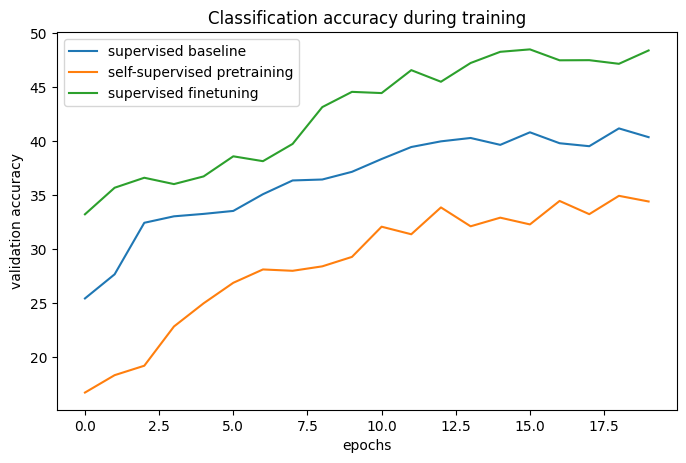

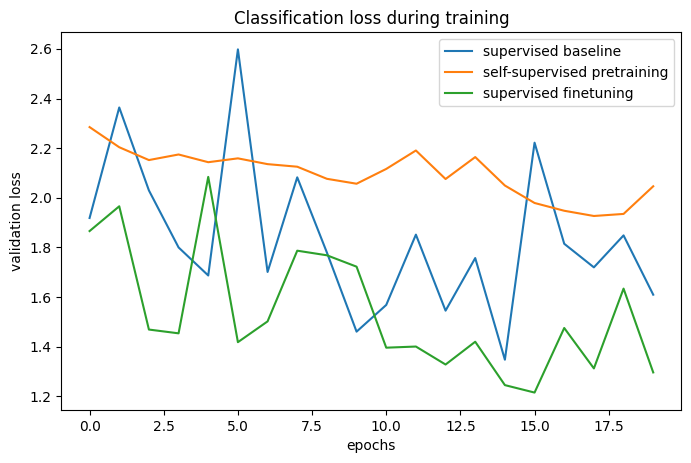

In [97]:

# The classification accuracies of the baseline and the pretraining + finetuning process:
def plot_training_curves(pretraining_history, finetuning_history, baseline_history):
    for metric_key, metric_name in zip(["acc", "loss"], ["accuracy", "loss"]):
        plt.figure(figsize=(8, 5), dpi=100)
        plt.plot(
            baseline_history[f"valid_{metric_key}"], label="supervised baseline"
        )
        plt.plot(
            pretraining_history[f"valid_{metric_key}"],
            label="self-supervised pretraining",
        )
        plt.plot(
            finetuning_history[f"valid_{metric_key}"],
            label="supervised finetuning",
        )
        plt.legend()
        plt.title(f"Classification {metric_name} during training")
        plt.xlabel("epochs")
        plt.ylabel(f"validation {metric_name}")


plot_training_curves(pretrain_history, finetune_history, base_history)

By comparing the training curves, we can see that when using contrastive
pretraining, a higher validation accuracy can be reached, paired with a lower
validation loss, which means that the pretrained network was able to generalize
better when seeing only a small amount of labeled examples.